In [1]:
# %%capture
# ! pip install nltk

# Import `nltk`

In [2]:
import nltk

In [3]:
# nltk.download_shell()

# Import dataset

In [4]:
messages = [line.rstrip() for line in open("smsspamcollection/SMSSpamCollection")]

In [5]:
print(len(messages))

5574


In [6]:
messages[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [7]:
for message_no, message in enumerate(messages[:5]):
    print(message_no, message)
    print()

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

1 ham	Ok lar... Joking wif u oni...

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

3 ham	U dun say so early hor... U c already then say...

4 ham	Nah I don't think he goes to usf, he lives around here though



Due to the spacing we can tell that this is a TSV ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

In [8]:
import pandas as pd

In [9]:
messages = pd.read_csv("smsspamcollection/SMSSpamCollection",
                       sep="\t",names=["label", "message"])

In [10]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
messages.groupby("label").describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

In [13]:
messages["length"] = messages["message"].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [14]:
avg_length = messages.groupby("label").mean()
avg_length

,length
label,
ham,71.482487
spam,138.670683


As we can see, the 'spam' messages are usually longer than 'ham' messages.

# Data visualization

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

<AxesSubplot:ylabel='Frequency'>

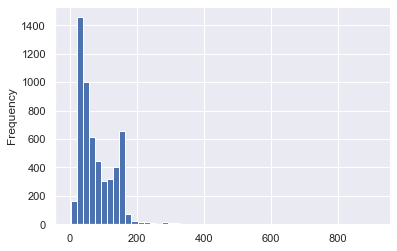

In [16]:
# Using pandas method
messages["length"].plot.hist(bins=50)

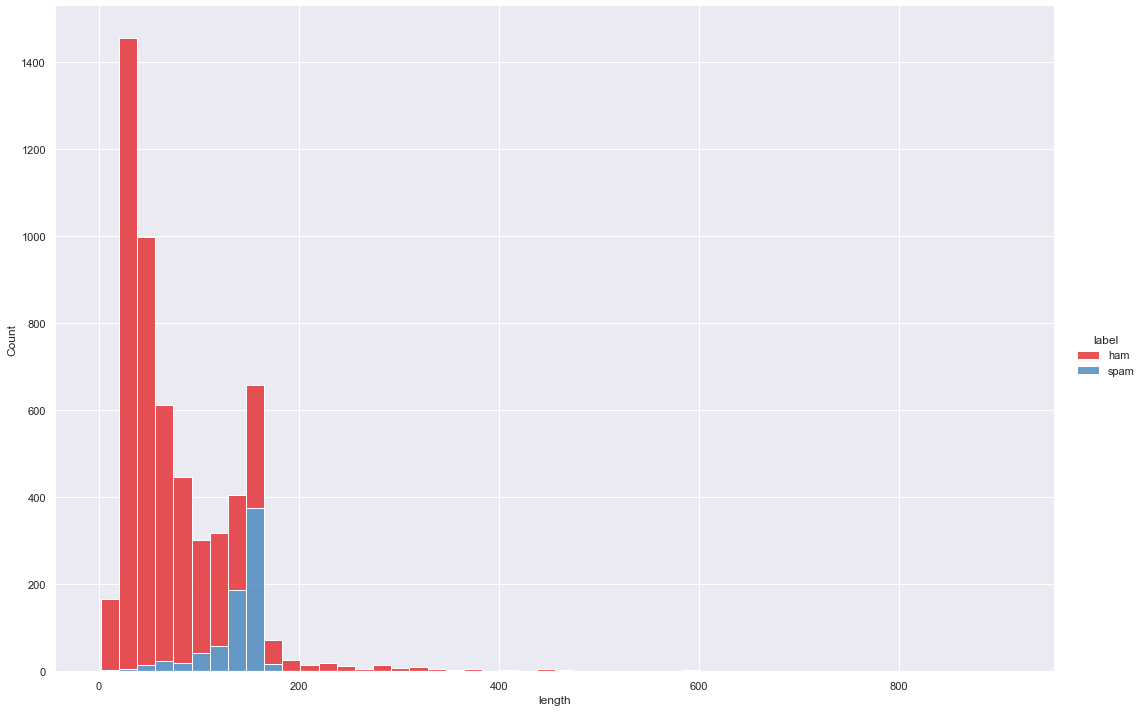

In [17]:
sns.displot(x="length", data=messages, 
             hue="label", palette="Set1", 
             multiple="stack", bins=50, 
             kind="hist", height=10, aspect=1.5)

In [18]:
avg_len_ham = avg_length.length[0]
avg_len_spam = avg_length.length[1]
avg_len_ham, avg_len_spam

(71.48248704663213, 138.6706827309237)

<AxesSubplot:xlabel='label', ylabel='length'>

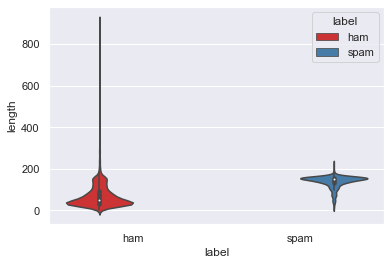

In [19]:
sns.violinplot(y="length", x="label",
               data=messages, hue="label", 
               palette="Set1")

In [20]:
messages["length"].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [21]:
messages[messages["length"]==910]["message"].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [22]:
#Or
messages.query("length == 910").message

1085    For me the love should start with attraction.i...
Name: message, dtype: object

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

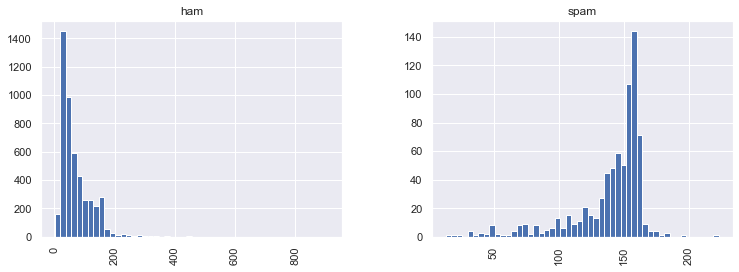

In [23]:
messages.hist(column="length", by="label", bins=50, figsize=(12,4))

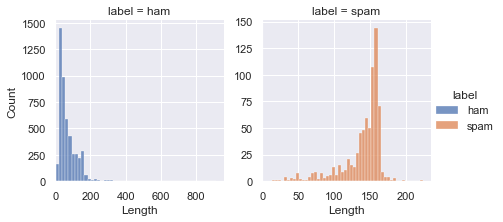

In [24]:
# Using seaborn
g = sns.FacetGrid(messages, col="label", sharey=False,
                  hue="label", sharex=False)
g.map_dataframe(sns.histplot,  bins=50,
                x="length")
g.set_axis_labels("Length", "Count")
g.set(xlim=(0, None))
g.add_legend()

# Text Pre-processing

Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.


In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use **apply()** in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in **string** library to get a quick list of all the possible punctuation:

In [25]:
from nltk.corpus import stopwords
from nltk.corpus import stopwords

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
def text_process(message):
    """
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    """
    # Return a list of characters in the message without any punctuations
    nopunc = [char for char in message if char not in string.punctuation]
    # Covert the list of chars to a string
    nopunc = "".join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words("english")]

### Tokenize the text
Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [29]:
messages["message"].head().apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [30]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

## Vectorization
Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:

Each vector will have as many dimensions as there are unique words in the SMS corpus.  We will first use SciKit Learn's **CountVectorizer**. This model will convert a collection of text documents to a matrix of token counts.

We can imagine this as a 2-Dimensional matrix. Where the 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message. 

For example:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>


Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages["message"])

In [33]:
# Total no of unique words
print(len(bow_transformer.vocabulary_))

11425


##### Let's take an example

In [34]:
mess4 = messages["message"][3]
mess4

'U dun say so early hor... U c already then say...'

In [35]:
bow4 = bow_transformer.transform([mess4])
print(bow4)
print("-"*20)
print("Shape = ",bow4.shape)

  (0, 4068)	2
  (0, 4629)	1
  (0, 5261)	1
  (0, 6204)	1
  (0, 6222)	1
  (0, 7186)	1
  (0, 9554)	2
--------------------
Shape =  (1, 11425)


We can see that the message has 7 words, out of which 2 are repeated, each twice. Remaining are stopwords.

In [36]:
# Let's see which words are repeated twice
print(bow_transformer.get_feature_names()[4068])
print("---")
print(bow_transformer.get_feature_names()[9554])

U
---
say


##### Now let's apply it to all the messages

In [37]:
messages_bow = bow_transformer.transform(messages["message"])

In [38]:
print("Shape of the Sparse Matrix: ", messages_bow.shape)

Shape of the Sparse Matrix:  (5572, 11425)


In [39]:
print("Amount of non zero occurrences: ",messages_bow.nnz)

Amount of non zero occurrences:  50548


These are basically total number of unique "non-stopwords" in the corpus.

In [40]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

sparsity: 0.07940295412668218


After the counting, the term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`.

____
### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer

In [46]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(messages_bow)

TfidfTransformer()

##### Coming back to our example

In [47]:
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 9554)	0.5385626262927564
  (0, 7186)	0.4389365653379857
  (0, 6222)	0.3187216892949149
  (0, 6204)	0.29953799723697416
  (0, 5261)	0.29729957405868723
  (0, 4629)	0.26619801906087187
  (0, 4068)	0.40832589933384067


##### Let's check 'IDF' of the word university in the corpus.

In [50]:
bow_transformer.vocabulary_

{'Go': 2060,
 'jurong': 7555,
 'point': 8917,
 'crazy': 5769,
 'Available': 1110,
 'bugis': 5218,
 'n': 8336,
 'great': 6937,
 'world': 11163,
 'la': 7668,
 'e': 6217,
 'buffet': 5217,
 'Cine': 1483,
 'got': 6906,
 'amore': 4653,
 'wat': 10965,
 'Ok': 3064,
 'lar': 7701,
 'Joking': 2451,
 'wif': 11072,
 'u': 10698,
 'oni': 8590,
 'Free': 1941,
 'entry': 6331,
 '2': 423,
 'wkly': 11123,
 'comp': 5619,
 'win': 11084,
 'FA': 1833,
 'Cup': 1551,
 'final': 6557,
 'tkts': 10512,
 '21st': 443,
 'May': 2804,
 '2005': 430,
 'Text': 3953,
 '87121': 871,
 'receive': 9252,
 'questionstd': 9159,
 'txt': 10686,
 'rateTCs': 9200,
 'apply': 4731,
 '08452810075over18s': 73,
 'U': 4068,
 'dun': 6204,
 'say': 9554,
 'early': 6222,
 'hor': 7186,
 'c': 5261,
 'already': 4629,
 'Nah': 2948,
 'dont': 6123,
 'think': 10433,
 'goes': 6877,
 'usf': 10799,
 'lives': 7842,
 'around': 4777,
 'though': 10450,
 'FreeMsg': 1943,
 'Hey': 2222,
 'darling': 5864,
 '3': 543,
 'weeks': 11011,
 'word': 11150,
 'back': 4893

In [51]:
bow_transformer.vocabulary_["university"]

10747

In [53]:
tfidf_transformer.idf_[bow_transformer.vocabulary_["university"]]

8.527076498901426

In [54]:
tfidf_transformer.idf_[bow_transformer.vocabulary_["u"]]

3.2800524267409408

##### Back to our work

In [56]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

# Training the classifier
With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.
We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier to start with:

In [57]:
from sklearn.naive_bayes import MultinomialNB

In [58]:
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages["label"])

In [59]:
spam_detect_model.predict(tfidf4)[0]

'ham'

In [60]:
messages["label"][3]

'ham'

Our prediction is actually correct here.

In [62]:
pred = spam_detect_model.predict(messages_tfidf)
pred

array(['ham', 'ham', 'spam', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
msg_train, msg_test, label_train, label_test = train_test_split(messages["message"], messages["label"], test_size=0.3)

We have taken the raw messages and labels while splitting above. Now we have to go through all the processes of ***Vectorization***, ***TfidfTransformer*** and training the ***Naive Bayes Classifier*** all over again. But we have an ace up our sleeves for that, i.e. Pipelines.

## Creating the pipeline

In [65]:
from sklearn.pipeline import Pipeline

In [66]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_process)),
    ("tfidf", TfidfTransformer()),
    ("classifier", MultinomialNB())
])

In [67]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001D0AFB43550>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [69]:
predictions = pipeline.predict(msg_test)

**When we call the `pipeline.fit()` method, it automatically applies `fit_transform()` on all but the last member of the pipeline, for which it only applies the `fit()` method. Here, all the members expext the last one should be transformers.
If we apply `pipeline.fit_transform()`, then it apllies `fit_transform()` to all the members. In this case, all the members of the pipeline can be transformers.**

# Evaluation

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1438
        spam       1.00      0.69      0.82       234

    accuracy                           0.96      1672
   macro avg       0.98      0.84      0.90      1672
weighted avg       0.96      0.96      0.95      1672



In [79]:
cnf = confusion_matrix(label_test, predictions)
print(cnf)

[[1438    0]
 [  73  161]]


<AxesSubplot:>

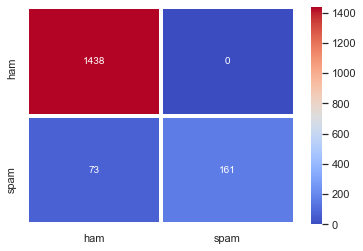

In [93]:
sns.heatmap(cnf, cmap="coolwarm", annot=True, 
            linecolor="white", linewidth=3, fmt="d",
           xticklabels=messages["label"].unique(),
           yticklabels=messages["label"].unique())

## Let's try a Random Forest Classifier

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_process)),
    ("tfidf", TfidfTransformer()),
    ("classifier", RandomForestClassifier())
])

In [96]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001D0AFB43550>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [97]:
predictions = pipeline.predict(msg_test)

In [98]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1438
        spam       0.99      0.75      0.85       234

    accuracy                           0.96      1672
   macro avg       0.98      0.87      0.92      1672
weighted avg       0.97      0.96      0.96      1672



In [99]:
cnf1 = confusion_matrix(label_test, predictions)
print(cnf1)

[[1437    1]
 [  59  175]]


<AxesSubplot:>

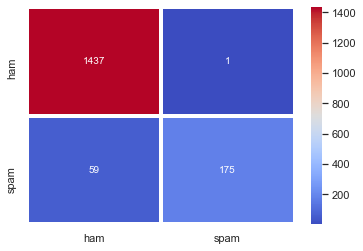

In [101]:
sns.heatmap(cnf1, cmap="coolwarm", annot=True, 
            linecolor="white", linewidth=3, fmt="d",
           xticklabels=messages["label"].unique(),
           yticklabels=messages["label"].unique())